In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from gensim.models import Word2Vec

In [3]:
df_train = pd.read_csv('train.csv')

In [4]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [60]:
df_train.iloc[0]

id                                                              0
qid1                                                            1
qid2                                                            2
question1       [step, step, guide, invest, share, market, india]
question2              [step, step, guide, invest, share, market]
is_duplicate                                                    0
q1_s             [step, step, guid, invest, share, market, india]
q2_s                    [step, step, guid, invest, share, market]
Name: 0, dtype: object

In [5]:
df_train.shape

(404290, 6)

In [6]:
df_train['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

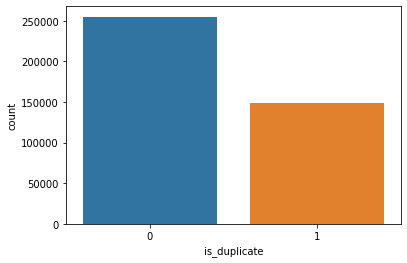

In [7]:
sns.countplot(x='is_duplicate', data=df_train)

In [8]:
final_list = list(set(df_train['qid1']) | set(df_train['qid1']))

In [9]:
print('Total number of unique questions : ', len(final_list))

Total number of unique questions :  290654


In [10]:
 df_train['question1'].isna().sum(), df_train['question2'].isna().sum()

(1, 2)

In [11]:
df_train.shape[0] - df_train.dropna(how='any').shape[0]

3

In [12]:
df_train = df_train.dropna(how='any')

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
# Use English stemmer.
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /home/prerit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
df_train['question1'] = df_train['question1'].str.lower()
df_train['question2'] = df_train['question2'].str.lower()

In [15]:
df_train[:5]['question1']

0    what is the step by step guide to invest in sh...
1    what is the story of kohinoor (koh-i-noor) dia...
2    how can i increase the speed of my internet co...
3    why am i mentally very lonely? how can i solve...
4    which one dissolve in water quikly sugar, salt...
Name: question1, dtype: object

In [16]:
import string
exclude = set(string.punctuation)

In [17]:
df_train['question1'] = df_train['question1'].apply(lambda x: ''.join(item for item in x if item not in exclude))
df_train['question2'] = df_train['question2'].apply(lambda x: ''.join(item for item in x if item not in exclude))

In [18]:
df_train[:5]['question1']

0    what is the step by step guide to invest in sh...
1       what is the story of kohinoor kohinoor diamond
2    how can i increase the speed of my internet co...
3     why am i mentally very lonely how can i solve it
4    which one dissolve in water quikly sugar salt ...
Name: question1, dtype: object

In [19]:
df_train['question1'] = df_train['question1'].str.split()
df_train['question2'] = df_train['question2'].str.split()

In [20]:
df_train['question1'] = df_train['question1'].apply(lambda x: [item for item in x if item not in stop])
df_train['question2'] = df_train['question2'].apply(lambda x: [item for item in x if item not in stop])

In [21]:
df_train[:5]['question1']

0    [step, step, guide, invest, share, market, india]
1                 [story, kohinoor, kohinoor, diamond]
2    [increase, speed, internet, connection, using,...
3                            [mentally, lonely, solve]
4    [one, dissolve, water, quikly, sugar, salt, me...
Name: question1, dtype: object

In [22]:
df_train['q1_s'] = df_train['question1'].apply(lambda x: [stemmer.stem(y) for y in x])
df_train['q2_s'] = df_train['question2'].apply(lambda x: [stemmer.stem(y) for y in x])

In [23]:
df_train[:5]['q1_s']

0     [step, step, guid, invest, share, market, india]
1                 [stori, kohinoor, kohinoor, diamond]
2        [increas, speed, internet, connect, use, vpn]
3                                 [mental, lone, solv]
4    [one, dissolv, water, quik, sugar, salt, metha...
Name: q1_s, dtype: object

In [58]:
df_train[:5]['q2_s']

0            [step, step, guid, invest, share, market]
1    [would, happen, indian, govern, stole, kohinoo...
2                [internet, speed, increas, hack, dns]
3           [find, remaind, math2324math, divid, 2423]
4                   [fish, would, surviv, salt, water]
Name: q2_s, dtype: object

In [24]:
df_train[:5]['question1']

0    [step, step, guide, invest, share, market, india]
1                 [story, kohinoor, kohinoor, diamond]
2    [increase, speed, internet, connection, using,...
3                            [mentally, lonely, solve]
4    [one, dissolve, water, quikly, sugar, salt, me...
Name: question1, dtype: object

In [53]:
df_train.to_pickle("dataset.csv")

In [56]:
counts = []
for a,b in zip(df_train.q1_s, df_train.q2_s): 
    t = len(list(set(a) & set(b)))
    counts.append(t)

In [61]:
df_train['common_words'] = counts

In [62]:
lengths = []
for a,b in zip(df_train.q1_s, df_train.q2_s): 
    t = abs(len(a) - len(b))
    lengths.append(t)

In [63]:
df_train['len_diff'] = lengths

In [64]:
df_train.to_pickle("dataset.pkl")

In [26]:
sentences = list(df_train['q1_s']) + list(df_train['q2_s'])

embed_size = 200

model = Word2Vec(sentences, size=embed_size, window=3, min_count=1, workers=4)

In [29]:
model.wv.most_similar(positive=['water'])

[('salt', 0.675682783126831),
 ('oxygen', 0.6237972974777222),
 ('bottl', 0.6147728562355042),
 ('droplet', 0.6146643757820129),
 ('treaty1960', 0.6125174164772034),
 ('tmc', 0.6071138978004456),
 ('drinkabl', 0.6059697866439819),
 ('desalin', 0.6042267084121704),
 ('kaveri', 0.6011481285095215),
 ('purifi', 0.5974735021591187)]

In [31]:
vecs = []
for i in list(df_train['q1_s'].values):
    vec = np.zeros(embed_size,)
    for x in i:
        vec = vec + model[x]
    vec = vec/len(i)
    vecs.append(vec)

vecs = np.array(vecs)
vecs.shape

/home/prerit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/prerit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [33]:
vecs[np.isnan(vecs)] = 0

# X = model[model.wv.vocab]
# pca = PCA(n_components=2)
# result = pca.fit_transform(X)
# pyplot.scatter(result[:, 0], result[:, 1])
# words = list(model.wv.vocab)
# for i, word in enumerate(words):
#     pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
# pyplot.show()

In [35]:
vecs2 = []
for i in list(df_train['q2_s']):
    vec = np.zeros(embed_size,)
    for x in i:
        vec = vec + model[x]
    vec = vec/len(i)
    vecs2.append(vec)

vecs2 = np.array(vecs2)
vecs2.shape

/home/prerit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/prerit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [37]:
vecs2[np.isnan(vecs2)] = 0

In [39]:
c = []
for i in range(vecs.shape[0]):
    result = 1 - spatial.distance.cosine(vecs[i], vecs2[i])
    c.append(result)

/home/prerit/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [40]:
preds = [1 if x > 0.95 else 0 for x in c]
true = list(df_train['is_duplicate'])
len(preds), len(true)

(404287, 404287)

In [52]:
print("Accuracy : ", accuracy_score(true, preds))
print("Precision : ", precision_score(true, preds))
print("Recall : ", recall_score(true, preds))

Accuracy :  0.641027290019219
Precision :  0.5252766061495201
Recall :  0.28784762466250846


In [44]:
cm = confusion_matrix(true, preds, normalize='true')

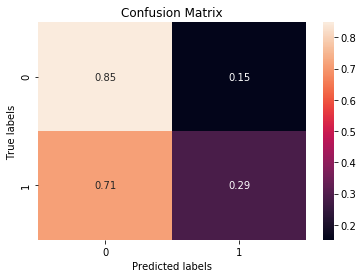

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);